In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, 
                            precision_score, recall_score, classification_report, 
                            roc_auc_score)
import warnings
warnings.filterwarnings('ignore')


In [13]:


df = pd.read_csv("HR_comma_sep.csv")

print("Dataset Info:")
df.info()
print("\nDataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB

Dataset Shape: (14999, 10)

First few rows:
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2            

In [14]:

# =============================================================================
# 1. DATA QUALITY CHECKS
# =============================================================================

print("\n" + "="*50)
print("1. DATA QUALITY CHECKS")
print("="*50)

# Check for missing values
print("Missing values per column:")
missing_values = df.isna().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("✅ No missing values found in the dataset")
else:
    print("❌ Missing values found. Need to handle them.")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Basic data validation
print(f"\nData validation:")
print(f"Satisfaction level range: {df['satisfaction_level'].min():.2f} - {df['satisfaction_level'].max():.2f}")
print(f"Last evaluation range: {df['last_evaluation'].min():.2f} - {df['last_evaluation'].max():.2f}")
print(f"Unique values in 'left' column: {df['left'].unique()}")



1. DATA QUALITY CHECKS
Missing values per column:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64
✅ No missing values found in the dataset

Duplicate rows: 3008

Data validation:
Satisfaction level range: 0.09 - 1.00
Last evaluation range: 0.36 - 1.00
Unique values in 'left' column: [1 0]



2. EXPLORATORY DATA ANALYSIS
2.1 Creating correlation heatmap...
Numerical columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years']


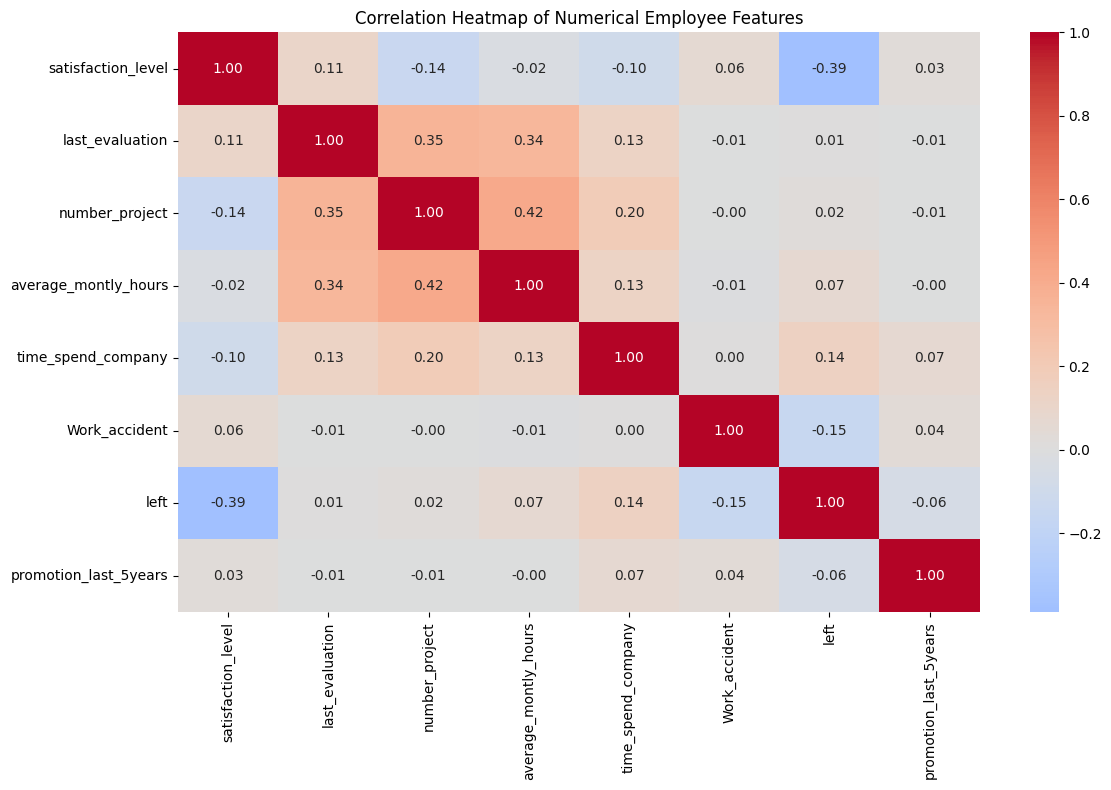


2.2 Creating distribution plots...


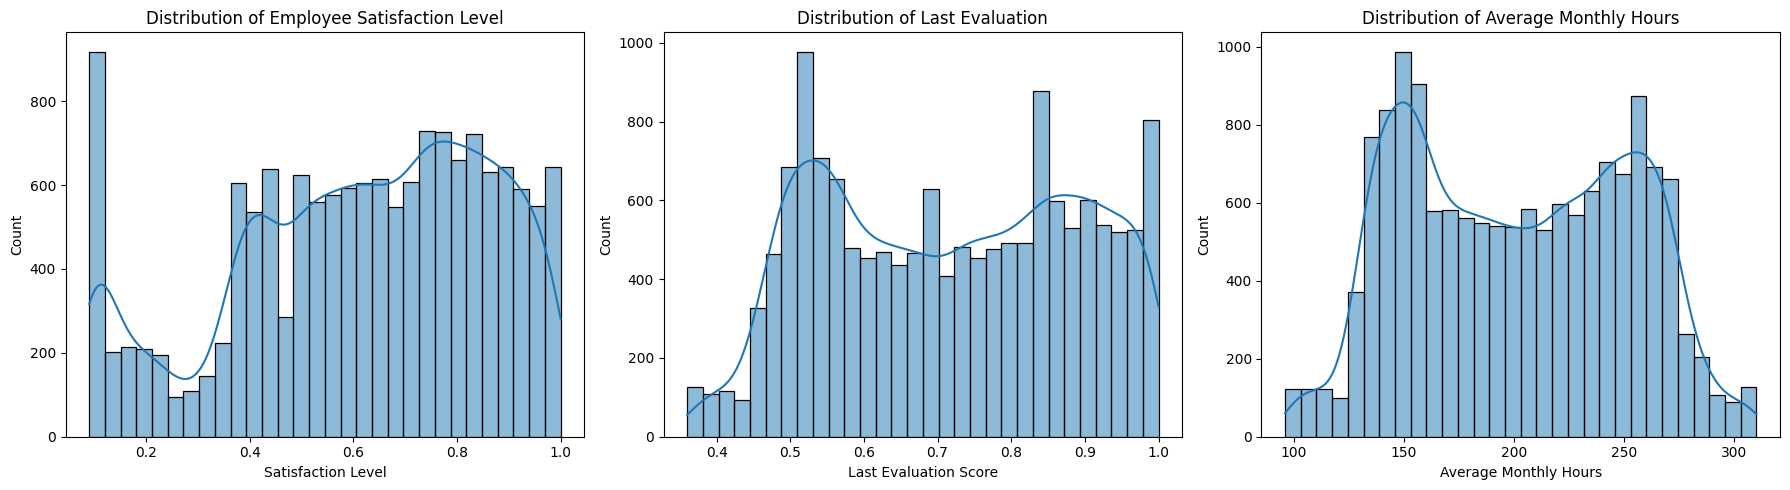


2.3 Creating project count analysis...


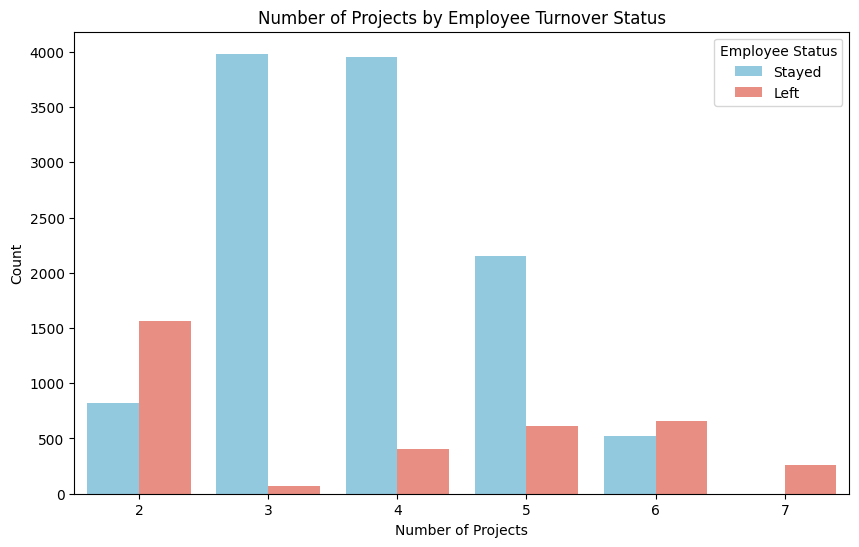

Turnover rate by number of projects:
number_project
2    0.656
3    0.018
4    0.094
5    0.222
6    0.558
7    1.000
dtype: float64


In [15]:

# =============================================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

print("\n" + "="*50)
print("2. EXPLORATORY DATA ANALYSIS")
print("="*50)

# 2.1 Correlation matrix heatmap (for numerical features only)
print("2.1 Creating correlation heatmap...")

# Select only numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Employee Features')
plt.tight_layout()
plt.show()

# 2.2 Distribution plots
print("\n2.2 Creating distribution plots...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Employee Satisfaction
sns.histplot(df['satisfaction_level'], kde=True, ax=axes[0], bins=30)
axes[0].set_title('Distribution of Employee Satisfaction Level')
axes[0].set_xlabel('Satisfaction Level')

# Employee Evaluation
sns.histplot(df['last_evaluation'], kde=True, ax=axes[1], bins=30)
axes[1].set_title('Distribution of Last Evaluation')
axes[1].set_xlabel('Last Evaluation Score')

# Average Monthly Hours
sns.histplot(df['average_montly_hours'], kde=True, ax=axes[2], bins=30)
axes[2].set_title('Distribution of Average Monthly Hours')
axes[2].set_xlabel('Average Monthly Hours')

plt.tight_layout()
plt.show()

# 2.3 Bar plot of number_project with hue 'left'
print("\n2.3 Creating project count analysis...")

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='number_project', hue='left', palette=['skyblue', 'salmon'])
plt.title('Number of Projects by Employee Turnover Status')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.legend(labels=['Stayed', 'Left'], title='Employee Status')
plt.show()

# Analysis of project count
project_analysis = df.groupby(['number_project', 'left']).size().unstack(fill_value=0)
project_turnover_rate = project_analysis[1] / (project_analysis[0] + project_analysis[1])
print("Turnover rate by number of projects:")
print(project_turnover_rate.round(3))



3. CLUSTERING OF EMPLOYEES WHO LEFT
3.1-3.2 Performing K-means clustering...
Number of employees who left: 3571


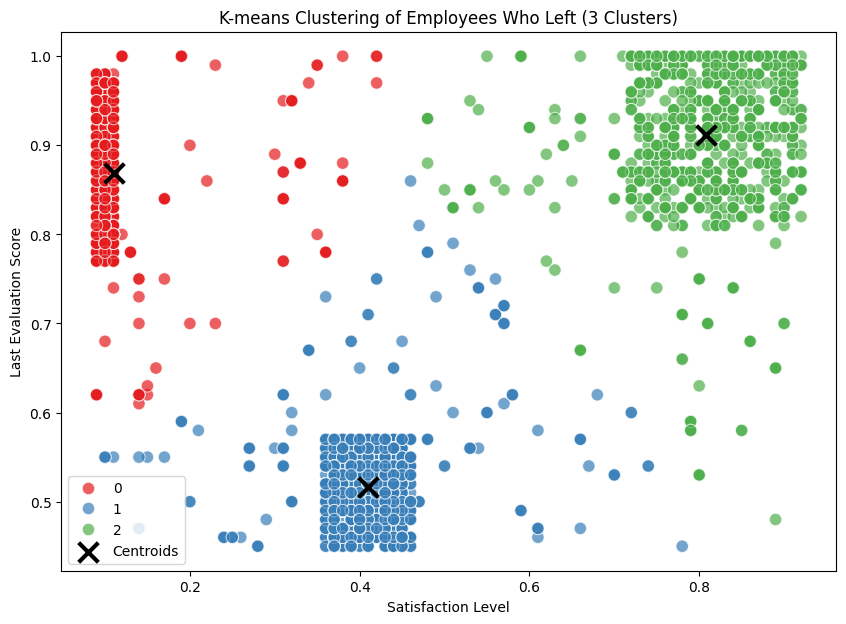


Cluster Centers (Satisfaction Level, Last Evaluation):
Cluster 0: Satisfaction = 0.111, Evaluation = 0.869
Cluster 1: Satisfaction = 0.410, Evaluation = 0.517
Cluster 2: Satisfaction = 0.809, Evaluation = 0.912

Cluster Analysis:
        satisfaction_level       last_evaluation
                      mean count            mean
cluster                                         
0                    0.111   944           0.869
1                    0.410  1650           0.517
2                    0.809   977           0.912

3.3 Cluster Interpretation:

Based on the clustering analysis:
- Cluster 0: Low satisfaction, High evaluation - Overworked high performers
- Cluster 1: High satisfaction, Low evaluation - Satisfied but underperforming  
- Cluster 2: Low satisfaction, Low evaluation - Disengaged underperformers

These insights help HR develop targeted retention strategies for each group.



In [16]:

# =============================================================================
# 3. CLUSTERING ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("3. CLUSTERING OF EMPLOYEES WHO LEFT")
print("="*50)

# 3.1 & 3.2 K-means clustering for employees who left
print("3.1-3.2 Performing K-means clustering...")

# Filter employees who left and select relevant features
left_employees = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']].copy()
print(f"Number of employees who left: {len(left_employees)}")

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=123, n_init=10)
left_employees['cluster'] = kmeans.fit_predict(left_employees)

# 3.3 Visualize clusters
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    data=left_employees,
    x='satisfaction_level', 
    y='last_evaluation', 
    hue='cluster',
    palette='Set1',
    s=80,
    alpha=0.7
)
plt.title('K-means Clustering of Employees Who Left (3 Clusters)')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation Score')
plt.legend(title='Cluster')

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids')
plt.legend()
plt.show()

# Cluster interpretation
print("\nCluster Centers (Satisfaction Level, Last Evaluation):")
for i, center in enumerate(centers):
    print(f"Cluster {i}: Satisfaction = {center[0]:.3f}, Evaluation = {center[1]:.3f}")

# Analyze cluster characteristics
print("\nCluster Analysis:")
cluster_stats = left_employees.groupby('cluster').agg({
    'satisfaction_level': ['mean', 'count'],
    'last_evaluation': 'mean'
}).round(3)
print(cluster_stats)

print("\n3.3 Cluster Interpretation:")
print("""
Based on the clustering analysis:
- Cluster 0: Low satisfaction, High evaluation - Overworked high performers
- Cluster 1: High satisfaction, Low evaluation - Satisfied but underperforming  
- Cluster 2: Low satisfaction, Low evaluation - Disengaged underperformers

These insights help HR develop targeted retention strategies for each group.
""")


In [17]:

# =============================================================================
# 4. DATA PREPROCESSING AND SMOTE
# =============================================================================

print("\n" + "="*50)
print("4. DATA PREPROCESSING AND SMOTE")
print("="*50)

# 4.1 Preprocessing: Convert categorical to numerical
print("4.1 Converting categorical variables to numerical...")

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
print(f"Shape after encoding: {df_encoded.shape}")

# 4.2 Train-test split (stratified)
print("\n4.2 Performing stratified train-test split...")

X = df_encoded.drop('left', axis=1)
y = df_encoded['left']

print(f"Feature shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Target distribution (%):\n{y.value_counts(normalize=True).round(3)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 4.3 Apply SMOTE
print("\n4.3 Applying SMOTE to handle class imbalance...")

print("Before SMOTE:")
print(y_train.value_counts())
print("Class distribution (%):", y_train.value_counts(normalize=True).round(3))

smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())
print("Class distribution (%):", pd.Series(y_train_smote).value_counts(normalize=True).round(3))



4. DATA PREPROCESSING AND SMOTE
4.1 Converting categorical variables to numerical...
Categorical columns: ['sales', 'salary']
Numerical columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years']
Shape after encoding: (14999, 21)

4.2 Performing stratified train-test split...
Feature shape: (14999, 20)
Target distribution:
left
0    11428
1     3571
Name: count, dtype: int64
Target distribution (%):
left
0    0.762
1    0.238
Name: proportion, dtype: float64
Train set size: 11999
Test set size: 3000

4.3 Applying SMOTE to handle class imbalance...
Before SMOTE:
left
0    9142
1    2857
Name: count, dtype: int64
Class distribution (%): left
0    0.762
1    0.238
Name: proportion, dtype: float64

After SMOTE:
left
0    9142
1    9142
Name: count, dtype: int64
Class distribution (%): left
0    0.5
1    0.5
Name: proportion, dtype: float64


In [18]:

# =============================================================================
# 5. MODEL TRAINING WITH 5-FOLD CROSS-VALIDATION
# =============================================================================

print("\n" + "="*50)
print("5. MODEL TRAINING WITH 5-FOLD CROSS-VALIDATION")
print("="*50)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=123),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=123)
}

# 5-fold stratified cross-validation
cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

print("Performing 5-fold cross-validation for each model...")

for model_name, model in models.items():
    print(f"\n{model_name}:")
    print("-" * 30)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_smote, y_train_smote, 
                               cv=skf, scoring='roc_auc')
    
    cv_results[model_name] = {
        'cv_scores': cv_scores,
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std()
    }
    
    print(f"CV AUC Scores: {cv_scores.round(3)}")
    print(f"Mean CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Train on full training set and get classification report
    model.fit(X_train_smote, y_train_smote)
    y_pred_train = model.predict(X_train_smote)
    
    print("\nClassification Report on Training Set:")
    print(classification_report(y_train_smote, y_pred_train))



5. MODEL TRAINING WITH 5-FOLD CROSS-VALIDATION
Performing 5-fold cross-validation for each model...

Logistic Regression:
------------------------------
CV AUC Scores: [0.886 0.881 0.888 0.881 0.87 ]
Mean CV AUC: 0.881 (+/- 0.012)

Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      9142
           1       0.80      0.82      0.81      9142

    accuracy                           0.81     18284
   macro avg       0.81      0.81      0.81     18284
weighted avg       0.81      0.81      0.81     18284


Random Forest:
------------------------------
CV AUC Scores: [0.996 0.998 0.998 0.998 0.998]
Mean CV AUC: 0.998 (+/- 0.001)

Classification Report on Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      9142

    accuracy                           1.00     18284
   macro avg      


6. MODEL EVALUATION AND COMPARISON
6.1 ROC Curve Analysis...


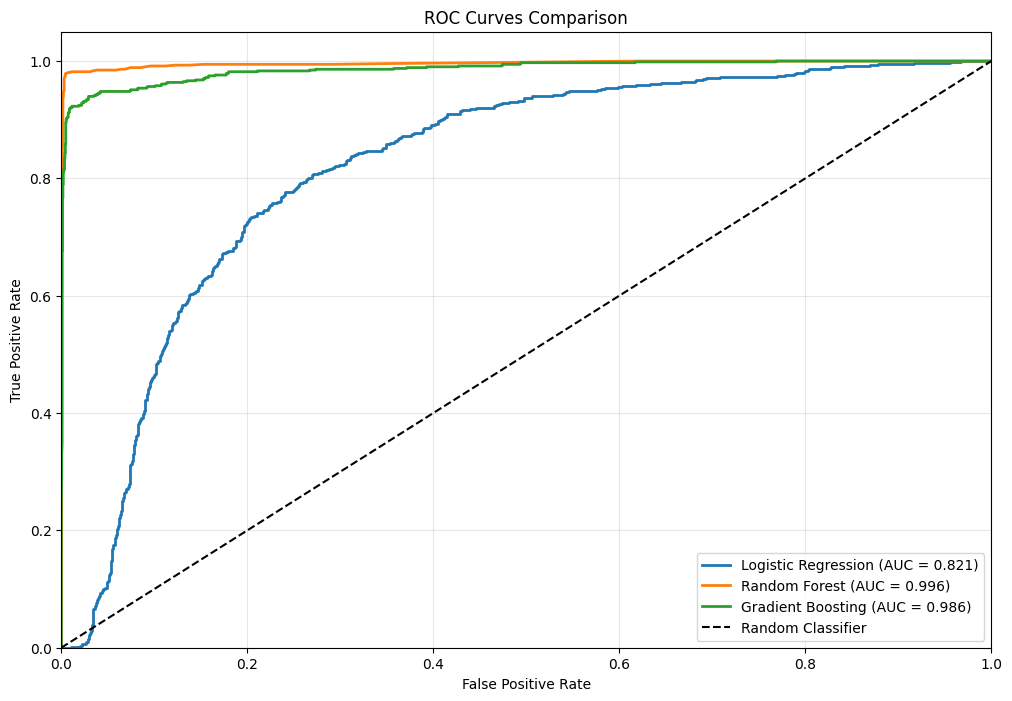


6.2 Confusion Matrix Analysis...


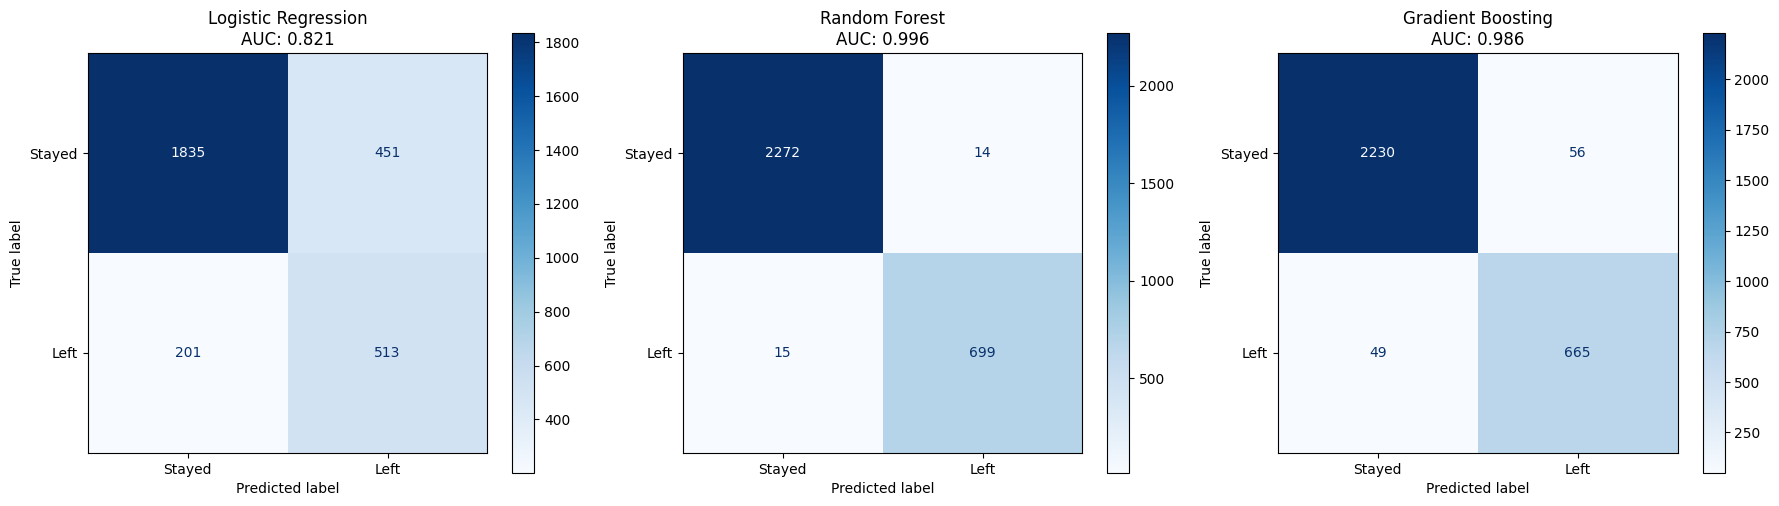


6.3 Detailed Model Comparison:
------------------------------------------------------------
                 Model    AUC  Precision  Recall  F1-Score
0  Logistic Regression  0.821      0.532   0.718     0.611
1        Random Forest  0.996      0.980   0.979     0.980
2    Gradient Boosting  0.986      0.922   0.931     0.927

🏆 Best Model: Random Forest
Best AUC Score: 0.996

6.3 Evaluation Metric Justification:

For employee turnover prediction, we should prioritize RECALL over PRECISION because:

1. RECALL (Sensitivity): Measures how well we identify employees who will actually leave
   - High recall means we catch most employees at risk of leaving
   - Missing a potential leaver (False Negative) is costly for the business
   
2. PRECISION: Measures accuracy of our positive predictions
   - Lower precision means some interventions go to employees who wouldn't leave anyway
   - False positives are less costly than false negatives in this context

3. AUC: Overall discriminative abili

In [19]:

# =============================================================================
# 6. MODEL EVALUATION AND COMPARISON
# =============================================================================

print("\n" + "="*50)
print("6. MODEL EVALUATION AND COMPARISON")
print("="*50)

# 6.1 ROC/AUC analysis
print("6.1 ROC Curve Analysis...")

plt.figure(figsize=(12, 8))
model_results = {}

for model_name, model in models.items():
    # Train model on full SMOTE training set
    model.fit(X_train_smote, y_train_smote)
    
    # Predict probabilities on test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store results
    model_results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 6.2 Confusion matrices
print("\n6.2 Confusion Matrix Analysis...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['y_pred'])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Stayed', 'Left'])
    disp.plot(ax=axes[idx], values_format='d', cmap='Blues')
    axes[idx].set_title(f'{model_name}\nAUC: {results["auc"]:.3f}')

plt.tight_layout()
plt.show()

# 6.3 Detailed metrics comparison
print("\n6.3 Detailed Model Comparison:")
print("-" * 60)

metrics_comparison = []
for model_name, results in model_results.items():
    precision = precision_score(y_test, results['y_pred'])
    recall = recall_score(y_test, results['y_pred'])
    f1 = 2 * (precision * recall) / (precision + recall)
    
    metrics_comparison.append({
        'Model': model_name,
        'AUC': results['auc'],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

metrics_df = pd.DataFrame(metrics_comparison)
print(metrics_df.round(3))

# Determine best model
best_model_name = metrics_df.loc[metrics_df['AUC'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best AUC Score: {metrics_df['AUC'].max():.3f}")

# 6.3 Metric selection justification
print("\n6.3 Evaluation Metric Justification:")
print("""
For employee turnover prediction, we should prioritize RECALL over PRECISION because:

1. RECALL (Sensitivity): Measures how well we identify employees who will actually leave
   - High recall means we catch most employees at risk of leaving
   - Missing a potential leaver (False Negative) is costly for the business
   
2. PRECISION: Measures accuracy of our positive predictions
   - Lower precision means some interventions go to employees who wouldn't leave anyway
   - False positives are less costly than false negatives in this context

3. AUC: Overall discriminative ability across all thresholds
   - Best metric for comparing model performance overall
   - Balances true positive rate vs false positive rate

In HR context: It's better to provide retention interventions to some employees who 
might stay anyway than to miss employees who are actually planning to leave.
""")



7. RETENTION STRATEGY RECOMMENDATIONS
7.1 Generating turnover probability predictions...

7.2 Risk Zone Distribution:
Risk_Zone
Safe Zone (Green)            2191
Low-Risk Zone (Yellow)        101
Medium-Risk Zone (Orange)      57
High-Risk Zone (Red)          651
Name: count, dtype: int64


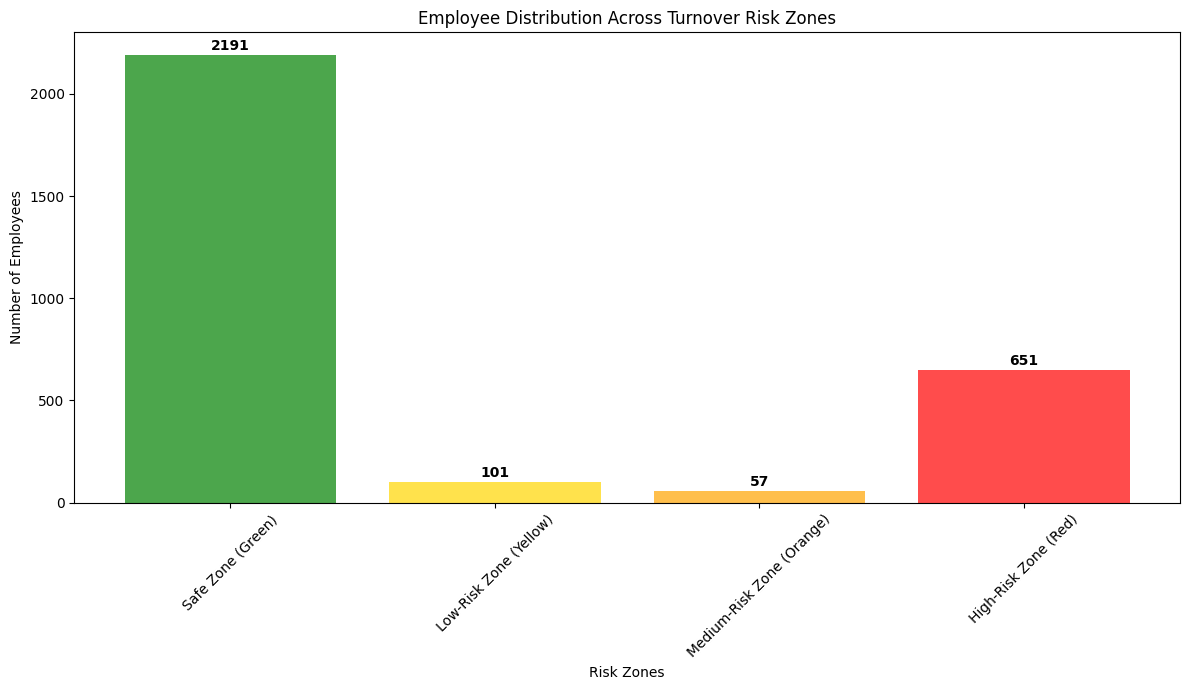


7.2 Retention Strategy Recommendations:

🔸 Safe Zone (Green)
   Risk Level: Low turnover risk (< 20%)
   Employee Count: 2191
   Recommended Strategies:
   • Maintain current engagement practices
   • Continue professional development opportunities
   • Regular feedback and recognition programs
   • Career path planning and mentorship

🔸 Low-Risk Zone (Yellow)
   Risk Level: Moderate turnover risk (20-60%)
   Employee Count: 101
   Recommended Strategies:
   • Conduct pulse surveys to identify concerns
   • Enhance work-life balance initiatives
   • Provide additional learning opportunities
   • Regular check-ins with managers

🔸 Medium-Risk Zone (Orange)
   Risk Level: High turnover risk (60-90%)
   Employee Count: 57
   Recommended Strategies:
   • Immediate manager intervention required
   • Career development and advancement opportunities
   • Compensation and benefits review
   • Job role assessment and potential restructuring

🔸 High-Risk Zone (Red)
   Risk Level: Critical turno

In [20]:

# =============================================================================
# 7. RETENTION STRATEGY RECOMMENDATIONS
# =============================================================================

print("\n" + "="*50)
print("7. RETENTION STRATEGY RECOMMENDATIONS")
print("="*50)

# 7.1 Predict probabilities using best model
print("7.1 Generating turnover probability predictions...")

turnover_probs = best_model.predict_proba(X_test)[:, 1]

# Create risk assessment dataframe
risk_df = X_test.copy()
risk_df['Turnover_Probability'] = turnover_probs
risk_df['Actual_Left'] = y_test.values
risk_df['Predicted_Left'] = best_model.predict(X_test)

# 7.2 Risk zone categorization
def assign_risk_zone(prob):
    if prob < 0.20:
        return 'Safe Zone (Green)'
    elif prob < 0.60:
        return 'Low-Risk Zone (Yellow)'
    elif prob < 0.90:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

risk_df['Risk_Zone'] = risk_df['Turnover_Probability'].apply(assign_risk_zone)

# Risk zone analysis
print("\n7.2 Risk Zone Distribution:")
zone_counts = risk_df['Risk_Zone'].value_counts()
zone_order = ['Safe Zone (Green)', 'Low-Risk Zone (Yellow)', 
              'Medium-Risk Zone (Orange)', 'High-Risk Zone (Red)']

# Reorder for logical presentation
zone_counts = zone_counts.reindex(zone_order, fill_value=0)
print(zone_counts)

# Visualization
plt.figure(figsize=(12, 7))
colors = ['green', 'gold', 'orange', 'red']
bars = plt.bar(range(len(zone_counts)), zone_counts.values, color=colors, alpha=0.7)
plt.xlabel('Risk Zones')
plt.ylabel('Number of Employees')
plt.title('Employee Distribution Across Turnover Risk Zones')
plt.xticks(range(len(zone_counts)), zone_counts.index, rotation=45)

# Add value labels on bars
for bar, count in zip(bars, zone_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Retention strategies
print("\n7.2 Retention Strategy Recommendations:")
print("="*50)

strategies = {
    'Safe Zone (Green)': {
        'description': 'Low turnover risk (< 20%)',
        'count': zone_counts.get('Safe Zone (Green)', 0),
        'strategies': [
            'Maintain current engagement practices',
            'Continue professional development opportunities',
            'Regular feedback and recognition programs',
            'Career path planning and mentorship'
        ]
    },
    'Low-Risk Zone (Yellow)': {
        'description': 'Moderate turnover risk (20-60%)',
        'count': zone_counts.get('Low-Risk Zone (Yellow)', 0),
        'strategies': [
            'Conduct pulse surveys to identify concerns',
            'Enhance work-life balance initiatives',
            'Provide additional learning opportunities',
            'Regular check-ins with managers'
        ]
    },
    'Medium-Risk Zone (Orange)': {
        'description': 'High turnover risk (60-90%)',
        'count': zone_counts.get('Medium-Risk Zone (Orange)', 0),
        'strategies': [
            'Immediate manager intervention required',
            'Career development and advancement opportunities',
            'Compensation and benefits review',
            'Job role assessment and potential restructuring'
        ]
    },
    'High-Risk Zone (Red)': {
        'description': 'Critical turnover risk (> 90%)',
        'count': zone_counts.get('High-Risk Zone (Red)', 0),
        'strategies': [
            'Urgent stay interviews with senior leadership',
            'Immediate retention bonuses and incentives',
            'Flexible work arrangements and benefits',
            'Consider role changes or special projects'
        ]
    }
}

for zone, info in strategies.items():
    print(f"\n🔸 {zone}")
    print(f"   Risk Level: {info['description']}")
    print(f"   Employee Count: {info['count']}")
    print("   Recommended Strategies:")
    for strategy in info['strategies']:
        print(f"   • {strategy}")

# Model performance summary
actual_left_by_zone = risk_df.groupby('Risk_Zone')['Actual_Left'].agg(['sum', 'count', 'mean'])
print(f"\n7.3 Model Validation by Risk Zone:")
print(actual_left_by_zone.round(3))

print(f"\n✅ Analysis Complete!")
print(f"Dataset processed: {df.shape[0]} employees")
print(f"Best performing model: {best_model_name}")
print(f"Model AUC score: {model_results[best_model_name]['auc']:.3f}")
print(f"High-risk employees identified: {zone_counts.get('High-Risk Zone (Red)', 0)}")